# Calibrate the two cameras

In [17]:
%load_ext autoreload
%autoreload 2
# from https://github.com/niconielsen32/ComputerVision/blob/master/cameraCalibration.py
# modified
import scipy
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from src.calibrator import Calibrator
from src.painting import Painting
from src.fusiello import Fusiello

img_path = 'assets/calibration_new/'
np.set_printoptions(precision=9,suppress=True)

################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.0001)

calibrator = Calibrator(img_path, file_selector='img-*.jpg', frameSize=(3648,2736), chessboardSize=(7,5), chessboard_square_mm=29.15, termination_criteria=criteria)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
cameraMatrix = calibrator.calibrate()
K1 = K2 = cameraMatrix

True
True
True
True
True
True
True
True
True
True

Camera calibrated:  0.4178454958506127
Camera Matrix:  [[2790.309555174    0.          1827.294490289]
 [   0.          2794.331225127 1402.003402332]
 [   0.             0.             1.         ]]
Distortion Parameters:  [[ 0.276835684 -2.987334413  0.000200718  0.000459765  6.717556836]]
Rotation Vectors:  (array([[-0.741710351],
       [-0.008121191],
       [-0.182649165]]), array([[-0.502831819],
       [ 0.0206692  ],
       [-0.270155676]]), array([[-0.761458074],
       [ 0.475766052],
       [ 1.298923406]]), array([[-0.481111883],
       [ 0.147694165],
       [ 0.626031822]]), array([[-0.205766933],
       [ 0.423029291],
       [ 1.380929133]]), array([[-0.389227399],
       [ 0.516166858],
       [ 1.495357835]]), array([[-0.690002517],
       [-0.074386684],
       [-0.096006821]]), array([[-0.631373827],
       [ 0.225575224],
       [ 0.904117617]]), array([[-0.316731336],
       [ 0.553202483],
       [ 1.602963142]]

P for img-*.jpg, index: 0
[[   2877.207463124    -756.498224578    1508.051795625 1238593.890789038]
 [   -353.408581161    1077.312427444    2913.486029536  779153.785240429]
 [      0.071859826      -0.670941059       0.738020502     703.829509771]]
P for img-*.jpg, index: 9
[[   2985.950063823    -177.040836834    1475.666400779 1138689.763032104]
 [   -433.867039057    1366.916826434    2777.984578413  767105.580506872]
 [      0.179166593      -0.560566988       0.808494888     754.870702407]]
Tcv [[-0.064831314]
 [ 0.746878889]
 [-0.661790624]
 [ 0.001412537]]
Tf [1350023.934330941  361846.601706618 -433241.683471677]
Sanity (P) [[   2877.207463124    -756.498224578    1508.051795625 1238593.890789038]
 [   -353.408581161    1077.312427444    2913.486029536  779153.785240429]
 [      0.071859826      -0.670941059       0.738020502     703.829509771]]
Sanity (K) [[ 2.877207463e+03 -7.564982246e+02  1.508051796e+03  2.975324543e+09]
 [-3.534085812e+02  1.077312427e+03  2.913486030e

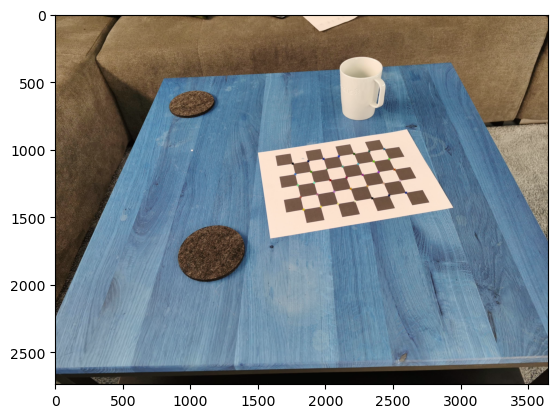

In [19]:
calibrator.plot_image(0)
P, _ = calibrator.calculateProjection(0)
Pp, _ = calibrator.calculateProjection(9)
K,_,_ = Fusiello.factorize(P)
Kp,_,_ = Fusiello.factorize(Pp)
print('Camera matrices')
print(K)
print(Kp)

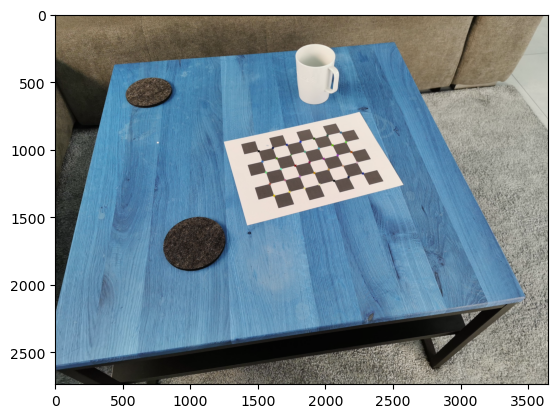

In [20]:
calibrator.plot_image(9)

> The following code is just for testing and not relevant to the topic

P for img-*.jpg, index: 0
[[   2877.207463124    -756.498224578    1508.051795625 1238593.890789038]
 [   -353.408581161    1077.312427444    2913.486029536  779153.785240429]
 [      0.071859826      -0.670941059       0.738020502     703.829509771]]
P for img-*.jpg, index: 9
[[   2985.950063823    -177.040836834    1475.666400779 1138689.763032104]
 [   -433.867039057    1366.916826434    2777.984578413  767105.580506872]
 [      0.179166593      -0.560566988       0.808494888     754.870702407]]
Tcv [[-0.064831314]
 [ 0.746878889]
 [-0.661790624]
 [ 0.001412537]]
Tf [1350023.934330941  361846.601706618 -433241.683471677]
Sanity (P) [[   2877.207463124    -756.498224578    1508.051795625 1238593.890789038]
 [   -353.408581161    1077.312427444    2913.486029536  779153.785240429]
 [      0.071859826      -0.670941059       0.738020502     703.829509771]]
Sanity (K) [[ 2.877207463e+03 -7.564982246e+02  1.508051796e+03  2.975324543e+09]
 [-3.534085812e+02  1.077312427e+03  2.913486030e

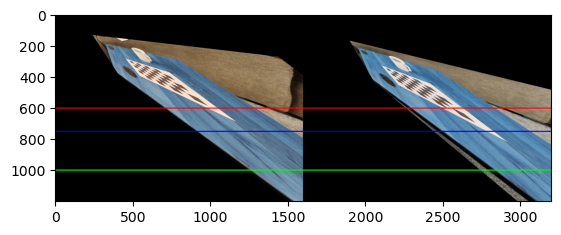

In [26]:
def fusiello(index1, index2, out_path=None):
    Mpl, _ = calibrator.calculateProjection(index1)
    Mpr, _ = calibrator.calculateProjection(index2)
    fusiello = Fusiello(Mpl, Mpr)

    print("Tl", fusiello.TFusl)
    print("Tr", fusiello.TFusr)

    paintingL = Painting(cv.imread(calibrator.images[index1])).warp_perspective(
        fusiello.TFusl, dimension=(3648*4, 2736*4)).resize((1600, 1200))
    paintingR = Painting(cv.imread(calibrator.images[index2])).warp_perspective(
        fusiello.TFusr, dimension=(3648*4, 2736*4)).resize((1600, 1200))

    # cv.warpPerspective(imgL)
    out = Painting(cv.hconcat([paintingL.image, paintingR.image]))
    out.add_horizontal_line(600, (255, 0, 0))
    out.add_horizontal_line(750, (0, 0, 255))
    out.add_horizontal_line(1000, (0, 255, 0))

    if (out_path):
        cv.imwrite(out_path, out.image)
    # plt.imshow(outL)
    out.plot()


fusiello(0, 9, 'assets/fusiello.jpg')

In [ ]:
Pp = np.array([[ 6.12430486e+02, -9.29557380e+02,  8.04197963e+02,
         9.98847541e+05],
       [ 8.35836177e+02,  5.46965600e+02,  6.29515656e+02,
         4.76432546e+05],
       [ 3.87999651e-04, -1.16635373e-01,  9.93174727e-01,
         7.88766677e+02]])
P = np.array([[-2.07810101e+02, -9.57532647e+02,  9.19420275e+02,
         4.99058538e+05],
       [ 6.41846643e+02,  1.77844561e+02,  9.33546842e+02,
         6.25080797e+05],
       [-3.98103114e-01,  4.43355772e-03,  9.17329959e-01,
         7.76363781e+02]])



print("P\n",P)
print("Pp\n",Pp)